In [25]:
import matplotlib.pyplot as plt
import numpy as np

from src.utils.general import load_json
from collections import defaultdict

def get_model_perf(path):
    data = load_json(path)
    domains = list(data.values())[0]['1'].keys()

    output = defaultdict(dict)
    for lim in data.keys():
        for domain in domains:
            accs = [data[lim][seed_num][domain] for seed_num in data[lim].keys()]
            print(domain, lim, accs)
            mean = np.mean(accs)
            std = np.std(accs)
            
            output[domain][int(lim)] = [mean, std]
    
    return output

def get_table_row(path, points=None, headers=True):
    """ formats the results to go into the table in the paper """
    header = ''
    msg = ''
    
    output = get_model_perf(path)
    if points is None:
        points = list(output.values())[0].keys()
        
    for domain in output.keys():
        for lim in points:
            head = 'k'.join(str(lim).rsplit('000', 1))
            header += f' & {head:<4}'
            if lim in output[domain]:
                mean = output[domain][lim][0]
                msg += f' & {mean:.1f}' #\std{{{row[1]:.1f}}}'
            else:
                msg += f' &  -  ' #\std{{{row[2]:.1f}}}'

    if headers: print(header)
        
    print(msg + ' \\\\')

def plot_iid_ood(path, iid_domain='snli', ood_domain='mnli', points=None, ax=None, **kwargs):
    output = get_model_perf(path)
    if points is None:
        points = sorted(list(output.values())[0].keys())
        
    iid_accs, ood_accs, iid_stds, ood_stds = [], [], [], []
    for lim in points:
        if lim in output[iid_domain]:
            iid_accs.append(output[iid_domain][lim][0])
            ood_accs.append(output[ood_domain][lim][0])
            
            iid_stds.append(output[iid_domain][lim][1])
            ood_stds.append(output[ood_domain][lim][1])

        else:
            print("skipping ", lim)

    if ax is None:
        fig, ax = plt.subplots()

    iid_accs = np.array(iid_accs)
    ood_accs = np.array(ood_accs)
    iid_stds = np.array(iid_stds)
    ood_stds = np.array(ood_stds)
    
    ax.plot(points, iid_accs, linestyle='-', marker='o', **kwargs)
    kwargs.pop('label') #removes labels
    
    ax.plot(points, ood_accs, linestyle='--', marker='o', **kwargs)
    ax.fill_between(points, iid_accs + iid_stds, iid_accs - iid_stds, alpha=0.05, **kwargs)
    ax.fill_between(points, ood_accs + ood_stds, ood_accs - ood_stds, alpha=0.05, **kwargs)
    
    return points


qqp 100 [60.78353779184804, 43.27265532251682, 66.82825484764543, 65.98733676296004, 65.86861891571033]
mrpc 100 [35.18840579710145, 59.47826086956521, 56.927536231884055, 50.72463768115942, 35.88405797101449]
qqp 1000 [81.43055005935892, 78.69014641867828, 73.18955282944202, 78.7198258804907, 79.65967550455085]
mrpc 1000 [67.53623188405797, 67.18840579710145, 72.23188405797102, 72.40579710144928, 72.52173913043478]
qqp 4000 [83.48832607835378, 83.46853977047883, 84.05223585278986, 84.2797783933518, 83.83458646616542]
mrpc 4000 [72.17391304347827, 73.44927536231884, 72.1159420289855, 72.98550724637681, 73.5072463768116]
qqp 10000 [84.51721408785122, 84.78432924416303, 84.28967154728927, 85.72417886822319, 85.48674317372378]
mrpc 10000 [72.7536231884058, 72.34782608695653, 73.91304347826086, 72.34782608695653, 72.52173913043478]
qqp 40000 [87.22793826671943, 87.42580134546894, 87.66323703996835, 87.57419865453106]
mrpc 40000 [71.3623188405797, 72.69565217391303, 69.79710144927537, 70.49

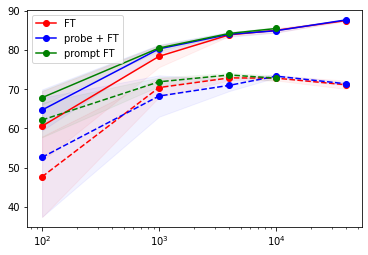

In [26]:
transformer = 'roberta-large'
dataset = 'qqp'
ood_dataset = 'mrpc'
# points = [100, 1000, 4000, 10_000, 40_000, 100_000, 200_000]

path_1 = f'models/{dataset}/finetune-{transformer}/curve.json'
path_2 = f'models/{dataset}/probe+ft-{transformer}/curve.json'
path_3 = f'models/{dataset}/prompt-{transformer}/curve.json'


fig, ax = plt.subplots()
plot_iid_ood(path_1, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='r', label='FT')
plot_iid_ood(path_2, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='b', label='probe + FT')
plot_iid_ood(path_3, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='g', label='prompt FT')

plt.legend()
ax.set_xscale('log')
plt.legend()

In [3]:
#path = 'models/snli/FT-bert-base/curve.json'

transformer = 'roberta-large'

path_1 = f'models/sst/freeze-{transformer}/curve.json'
path_2 = f'models/sst/finetune-{transformer}/curve.json'
path_3 = f'models/sst/probe+ft-{transformer}/curve.json'
path_4 = f'models/sst/prompt-{transformer}/curve.json'

get_table_row(path_1, [100, 1000, 4000, 10000, 40000])
get_table_row(path_2, [100, 1000, 4000, 10000, 40000], headers=False)
get_table_row(path_3, [100, 1000, 4000, 10000, 40000], headers=False)
get_table_row(path_4, [100, 1000, 4000, 10000, 40000], headers=False)


FileNotFoundError: [Errno 2] No such file or directory: 'models/sst/freeze-roberta-large/curve.json'

In [ ]:
def iid_ood_plot(path, **kwargs):
    output = get_model_perf(path)
    
    domains = list(output.keys())
    lims = sorted(output[domains[0]].keys())

    points = []
    for lim in lims:
        iid_acc = output[domains[0]][lim][0]
        ood_acc = output[domains[1]][lim][0]
        points.append((ood_acc, iid_acc))
    plt.plot(*zip(*points), marker='o', markersize=8, **kwargs)
    

In [ ]:
for trans_name in ['roberta', 'bert']:
    for size in ['base', 'large']:
        path_1 = f'models/snli/FT-{trans_name}-{size}/curve.json'
        path_2 = f'models/snli/prompt-{trans_name}-{size}/curve.json'
        iid_ood_plot(path_1, linestyle='--')
        iid_ood_plot(path_2, linestyle='-')
        plt.show()

In [ ]:
def get_model_perf(path, points=[10, 100, 1000, 5000, 10000]):
    data = load_json(path)
    domains = list(data.values())[0]['1'].keys()

    output = defaultdict(dict)
    for lim in data.keys():
        if len(data[lim].keys()) < 5:
            continue
        
        for domain in domains:
            accs = [data[lim][seed_num][domain] for seed_num in data[lim].keys()]
            mean = np.mean(accs)
            std = np.std(accs)
            output[domain][int(lim)] = [mean, std]
            
    return output

def get_table_row(path, points=[10, 100, 1000, 5000, 10000]):
    """ formats the results to go into the table in the paper """
    output = get_model_perf(path)
    header = ''
    msg = ''
    for domain in output.keys():
        for lim in points:
            head = 'k'.join(str(lim).rsplit('000', 1))
            header += f' & {head:<4}'
            if lim in output[domain]:
                mean = output[domain][lim][0]
                msg += f' & {mean:.1f}' #\std{{{row[1]:.1f}}}'
            else:
                msg += f' &  -  ' #\std{{{row[2]:.1f}}}'
    print(header)
    print(msg)
        